In [1]:
%%capture
%cd ../../
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

from ml_common.engineer import get_change_since_prev_session
from ml_common.prep import Splitter

from preduce.prepare.filter import drop_samples_outside_study_date, keep_only_one_per_week
from preduce.symp.label import get_symptom_labels
from preduce.acu.label import get_event_labels
from preduce.summarize import get_patient_characteristics, pre_and_post_treatment_missingness_summary

pd.set_option('display.max_rows', 150)

In [4]:
symp = pd.read_parquet('./data/external/symptom.parquet.gzip')
data = pd.read_parquet('./data/treatment_centered_clinical_dataset.parquet.gzip')
data = get_change_since_prev_session(data)
data = keep_only_one_per_week(data)
data = drop_samples_outside_study_date(data)
data = get_symptom_labels(data, symp)

Getting symptom labels...: 100%|██████████| 1097/1097 [00:06<00:00, 178.64it/s]


In [6]:
# extract ED within 30 days label
emerg = pd.read_parquet('./data/external/emergency_room_visit.parquet.gzip')
data = get_event_labels(data, emerg, event_name='ED_visit')

# extract death within 30 days label
data['target_death'] = (data['date_of_death'] - data['treatment_date']).dt.days < 30

100%|██████████| 1097/1097 [00:04<00:00, 239.77it/s]


# Missingness

In [7]:
# Compute rates of ESAS symptom score missingness in the cohort
symps = ['nausea', 'appetite', 'pain', 'shortness_of_breath', 'tiredness', 'drowsiness', 'depression', 'anxiety', 'well_being']
pretreatment_cols = [f'esas_{symp}' for symp in symps]
posttreatment_cols = [f'target_{col}_survey_date' for col in pretreatment_cols]
event_cols = [f'target_{col}_change' for col in pretreatment_cols]
splitter = Splitter()
dev_cohort, test_cohort = splitter.temporal_split(data, split_date='2017-10-01')
for name, cohort in {'test': test_cohort, 'dev': dev_cohort}.items():
    result = pre_and_post_treatment_missingness_summary(cohort, pretreatment_cols, posttreatment_cols, event_cols)
    result.to_csv(f'./result/tables/missingness_summary_{name}_cohort.csv')
result[['any_missingness_trt', 'target_missingness_trt', 'event_rate_trt', 'any_missingness_mrn', 'event_rate_mrn']]

,any_missingness_trt,target_missingness_trt,event_rate_trt,any_missingness_mrn,event_rate_mrn
esas_nausea,10392 (41.6),4647 (24.1),1829 (12.5),2062 (70.7),801 (31.8)
esas_appetite,10367 (41.5),4621 (24.0),1949 (13.3),2055 (70.5),891 (35.4)
esas_pain,10356 (41.4),4633 (24.0),1955 (13.4),2062 (70.7),893 (35.5)
esas_shortness_of_breath,10366 (41.5),4627 (24.0),2152 (14.7),2064 (70.8),912 (36.3)
esas_tiredness,10367 (41.5),4632 (24.1),2695 (18.4),2063 (70.8),1111 (44.1)
esas_drowsiness,10401 (41.6),4652 (24.2),2270 (15.6),2063 (70.8),1001 (39.8)
esas_depression,10400 (41.6),4637 (24.1),2101 (14.4),2065 (70.8),923 (36.7)
esas_anxiety,10403 (41.6),4643 (24.1),2103 (14.4),2069 (71.0),934 (37.2)
esas_well_being,10551 (42.2),4666 (24.4),2517 (17.4),2079 (71.3),1079 (43.0)
Mean,10400 (41.6),4639 (24.1),2174 (14.9),2064 (70.8),949 (37.7)


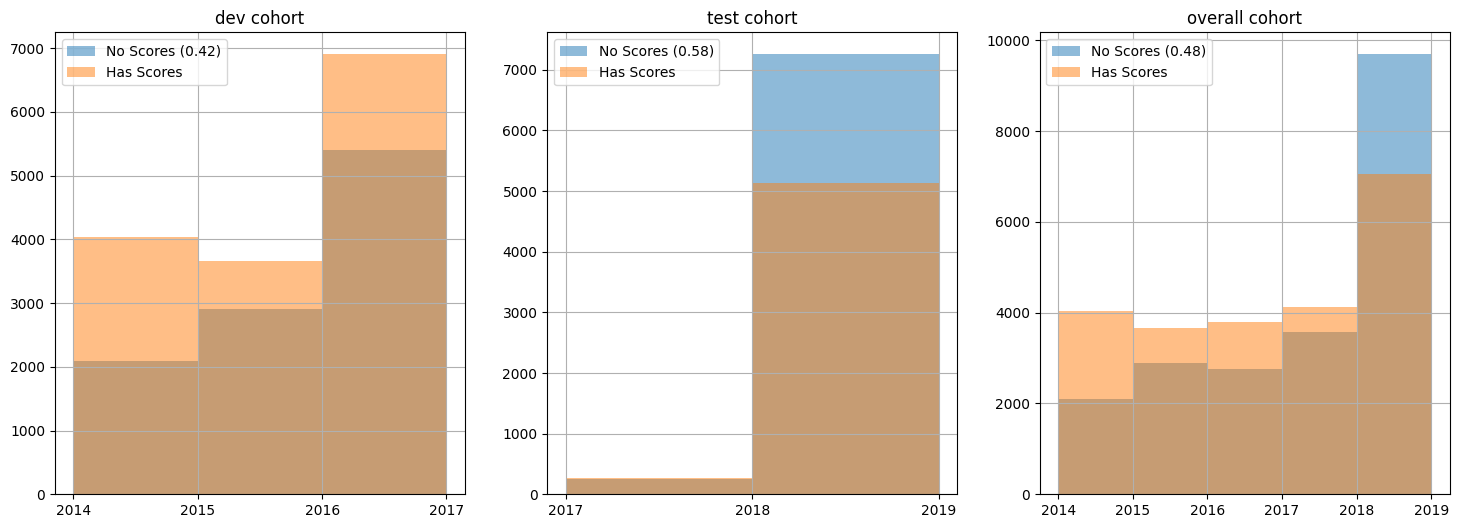

In [9]:
# Comapre the cohort with missing ESAS symptom scores and the cohort without missing ESAS symptom scores
cancer_cols = [col for col in dev_cohort.columns if col.startswith('cancer_site')]
top_cancers = dev_cohort[cancer_cols].sum().sort_values(ascending=False)[:5].index
top_regimens = dev_cohort['regimen'].value_counts()[:5].index
extra_targets = ['target_ED_visit', 'target_death']
kwargs = dict(top_cancers=top_cancers, top_regimens=top_regimens, targets=extra_targets)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
cohorts = {'dev': dev_cohort, 'test': test_cohort, 'overall': data}
result = dict()
for i, (name, cohort) in enumerate(cohorts.items()):
    mask = cohort[event_cols].notnull().any(axis=1)

    # compare with respect to treatments
    no_scores_trts, has_scores_trts = cohort[~mask], cohort[mask]
    N_ns, N_hs = len(no_scores_trts), len(has_scores_trts)
    result[(name, 'No Scores', f'Treatments (N={N_ns})')] = get_patient_characteristics(no_scores_trts, **kwargs)
    result[(name, 'Has Scores', f'Treatments (N={N_hs})')] = get_patient_characteristics(has_scores_trts,  **kwargs)

    # compare with respect to patients
    no_scores_mrns = no_scores_trts.groupby('mrn').last()
    no_scores_mrns['target_ED_visit'] = no_scores_trts.groupby('mrn')['target_ED_visit'].apply(any)
    has_scores_mrns = has_scores_trts.groupby('mrn').last()
    has_scores_mrns['target_ED_visit'] = has_scores_trts.groupby('mrn')['target_ED_visit'].apply(any)
    N_ns, N_hs = len(no_scores_mrns), len(has_scores_mrns)
    result[(name, 'No Scores', f'Patients (N={N_ns})')] = get_patient_characteristics(no_scores_mrns, **kwargs)
    result[(name, 'Has Scores', f'Patients (N={N_hs})')] = get_patient_characteristics(has_scores_mrns, **kwargs)

    # comapre their time frames
    min_year = cohort['treatment_date'].dt.year.min()
    max_year = cohort['treatment_date'].dt.year.max()
    bins = max_year - min_year
    perc = len(no_scores_trts) / (len(no_scores_trts) + len(has_scores_trts))
    no_scores_trts['treatment_date'].dt.year.hist(bins=bins, ax=axes[i], alpha=0.5, label=f'No Scores ({perc:.2f})')
    has_scores_trts['treatment_date'].dt.year.hist(bins=bins, ax=axes[i], alpha=0.5, label='Has Scores')
    axes[i].legend()
    axes[i].set(xticks=range(min_year, max_year+1), xticklabels=range(min_year, max_year+1), title=f'{name} cohort')

result = pd.DataFrame(result)
result.to_csv('./result/tables/missingness_cohort_characteristics.csv')